In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TF2 Retraining
To use please create the folder structure

/.

/Klassen

/Klassen/Orane

/Klassen/Kiwi etc.

/tmp

The algorith will automaticly create as many classes as the folders for the model. In the class folders plase leave only pictures of the corresponding class. How big the picture is and the naming are not important. In tmp folder the model will be saved. Please create a file /tmp/labels.txt manualy and put in the labels of the classes. The order is alphabeticaly. The ML will deliver the index of the labels and the text document the naming for the index.

In [ ]:
import itertools
import os

#import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

from PIL import Image

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

from google.colab import drive
drive.mount('/Bilderkennung')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\users\rybak\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-11f8932716c4>", line 7, in <module>
    import tensorflow as tf
  File "C:\Users\Rybak\AppData\Roaming\Python\Python37\site-packages\tensorflow\__init__.py", line 101, in <module>
    from tensorflow_core import *
  File "C:\Users\Rybak\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\__init__.py", line 40, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "C:\Users\Rybak\AppData\Roaming\Python\Python37\site-packages\tensorflow\__init__.py", line 50, in __getattr__
    module = self._load()
  File "C:\Users\Rybak\AppData\Roaming\Python\Python37\site-packages\tensorflow\__init__.py", line 44, in _load
    module = _importlib.import_module(self.__name__)
  File "c:\users\rybak\appdata\local\

## Load Model Architecture
Only one of the following two block should be executed. There are different Model architectures loaded from TFHub repository. Check of www.tfhub.dev for more information.

In [0]:
# TF2 Saved Model - SSDV2 + inception
module_selection = ("mobilenet_v2_100_224", 224) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 35 #@param {type:"integer"}

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [0]:
# TF2 Saved Model - SSDV1 TFLite
module_selection = ("mobilenet_v1_100_224", 224) #@param ["(\"mobilenet_v1_100_224\", 224)", "(\"mobilenet_v1_1.0_224_quantized\", 224)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/classification/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 35 #@param {type:"integer"}

Using https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/4 with input size (224, 224)


## Setup the Class Folder

In [0]:
# learning data
data_dir = '/Bilderkennung/My Drive/Bilderkennung/Klassen'
data_dir

'/Bilderkennung/My Drive/Bilderkennung/Klassen'

## Setup data processing

In [0]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 662 images belonging to 3 classes.
Found 2653 images belonging to 3 classes.


## Setup Model and Training Parameter

In [0]:
do_fine_tuning = False #@param {type:"boolean"}

In [0]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   multiple                  2257984   
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


Model Training

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
  metrics=['accuracy'])

In [0]:
valid_generator.samples

662

In [0]:
valid_generator.batch_size

35

## Fit the Model

In [0]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit_generator(
    train_generator,
    epochs=10, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 75 steps, validate for 18 steps
Epoch 1/10
 3/75 [>.............................] - ETA: 12:29 - loss: 1.0684 - accuracy: 0.5238

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


75/75 [==============================] - 840s 11s/step - loss: 0.5904 - accuracy: 0.8514 - val_loss: 0.4771 - val_accuracy: 0.9175
Epoch 2/10
75/75 [==============================] - 56s 745ms/step - loss: 0.4632 - accuracy: 0.9232 - val_loss: 0.4359 - val_accuracy: 0.9413
Epoch 3/10
75/75 [==============================] - 55s 728ms/step - loss: 0.4396 - accuracy: 0.9423 - val_loss: 0.4237 - val_accuracy: 0.9476
Epoch 4/10
75/75 [==============================] - 55s 737ms/step - loss: 0.4277 - accuracy: 0.9412 - val_loss: 0.4138 - val_accuracy: 0.9524
Epoch 5/10
75/75 [==============================] - 56s 743ms/step - loss: 0.4191 - accuracy: 0.9530 - val_loss: 0.4103 - val_accuracy: 0.9556
Epoch 6/10
75/75 [==============================] - 54s 722ms/step - loss: 0.4138 - accuracy: 0.9557 - val_loss: 0.4010 - val_accuracy: 0.9571
Epoch 7/10
75/75 [==============================] - 55s 730ms/step - loss: 0.4017 - accuracy: 0.9614 - val_loss: 0.4019 - val_accuracy: 0.9651
Epoch 8/10


## Graphical Representation

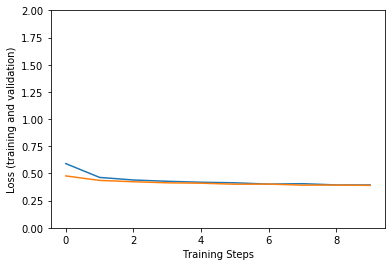

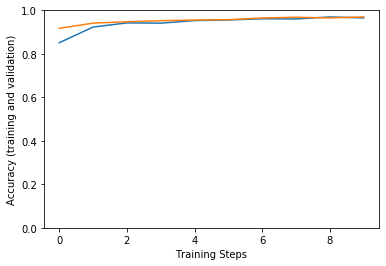

In [0]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

# Save Model

In [0]:
saved_model_path = "/Bilderkennung/My Drive/Bilderkennung/tmp"
tf.saved_model.save(model, saved_model_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /Bilderkennung/My Drive/Bilderkennung/tmp/assets


INFO:tensorflow:Assets written to: /Bilderkennung/My Drive/Bilderkennung/tmp/assets


# Prediction of a single File

Shape of Image:  (224, 224, 3)
Class and Number of Classes:  (1, 3) Probability of Classses:  [[ 4.1 88.   7.8]]
Prediction:  1 with Label: Kiwi


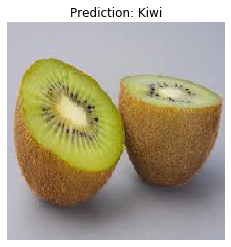

In [0]:
# how to predict a single picture
# https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

from keras.preprocessing import image
import numpy as np

# dimensions of our images
img_width, img_height = 224, 224

# predicting images
#img = image.load_img('/Bilderkennung/My Drive/Bilderkennung/orange.jpg', target_size=(img_width, img_height))
#img = image.load_img('/Bilderkennung/My Drive/Bilderkennung/banane.jpg', target_size=(img_width, img_height))
img = image.load_img('/Bilderkennung/My Drive/Bilderkennung/kiwi.jpg', target_size=(img_width, img_height))
#img = image.load_img('/Bilderkennung/My Drive/Bilderkennung/alles.jpg', target_size=(img_width, img_height))
img_n = np.array(img)/255.0
print('Shape of Image: ', img_n.shape)
# model prediction
result = model.predict(img_n[np.newaxis, ...])
print('Class and Number of Classes: ', result.shape, 'Probability of Classses: ', np.around(result * 100, decimals=1) )
#top probability class
predicted_class = np.argmax(result[0], axis=-1)
# labels
labels_path = '/Bilderkennung/My Drive/Bilderkennung/tmp/labels.txt'
imagenet_labels = np.array(open(labels_path).read().splitlines())
print('Prediction: ', predicted_class, "with Label: " + imagenet_labels[predicted_class])
# plot with labels
plt.imshow(img)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())
# 0 - banane
# 1 - kiwi
# 2 - orange

# Load saved_model


## with Tensorflow

In [0]:
# https://www.tensorflow.org/api_docs/python/tf/saved_model/load
# Keras models are trackable, so they can be saved to SavedModel. 
# The object returned by tf.saved_model.load is not a Keras object (i.e. doesn't have .fit, .predict, etc. methods).
# Use tf.keras.models.load_model to restore the Keras model.
#from keras.models import load_model

model = tf.keras.models.load_model('/Bilderkennung/My Drive/Bilderkennung/tmp/')
#loaded_model
model

# Tutorial
Tensorflow 2 Retraining Alorithm:

https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb#scrollTo=FlsEcKVeuCnf
https://github.com/tensorflow/hub